# 🌊 Predicting Lithologies for the Ocean Drilling Program

In this assessment, you are the **boss of your own AI consluting company**: ***<span style="color:teal">MSC-AI Consulting</span>***. Your client is the **Integrated Ocean Drilling Program** (IODP), a reputable research institution with the mission of drilling the seafloor in order to understand the dynamic of the Earth and its past climates. You know that IODP has approached other, competing AI consulting companies: so don't let them see your answer, and try to do better than them to convince the client to give you the best score!

IODP routinely uses two different types of data:

1. **Cores**: A core is a piece of rock recovered from the seafloor. This allows geologist to perform analysis on the material, and to identify exactly what type of rock is present. Cores are however difficult to recover, and expensive. You can <a href="https://www.ga.gov.au/scientific-topics/marine/survey-techniques/sedimentary-coring-drilling">learn more about cores here if you want</a>.
2. **Downhole (wireline) logs**: IODP can also use downhole or wireline logs, i.e. data from  instruments that are lowered in a drill hole by research geologists. Drill holes can be very deep, down to several kilometers below the water-sediment interface (the unit used is `Depth_WMSF`, also known as meters below seafloor - larger numbers means deeper in the well). Downhole logs record properties of the rocks they measure, including natural gamma radiation (total gamma ray `HCGR`, potassium `HFK`, thorium `HTHO`, uranium `HURA`, shallow and deep penetration resistivity (`IDPH` and `IMPH`) and neutron porosity (`SFLU`). The goal is to use these properties measured continuously to estimate the **lithology** (i.e. type of rock) present. More details are provided <a href="https://en.wikipedia.org/wiki/Well_logging">on this website if you are interested</a>.

IODP has been experimenting recently with a brand new type of downhold log called <code>munsel_color</code>. They reckon that this new log type alongside the others could help in the identification of the lithology from wireline log data. They are very excited to test this, and have contacted you to help them - so you see this type of log for the first time.

## ⛴️ Your task

You are given drilling and logging data (`data/lithology.csv`) that can be used for training and testing, and that contains data from a single well (a drilling location) from 0 to 450 MWSF. In the context of the Integrated Ocean Drilling Program (IODP), the acronym **WMSF** stands for **Water-Depth Meters Below Seafloor**. This unit of measurement is commonly used in ocean drilling and marine geology to specify the depth below the seafloor at which samples are taken or observations are made. 

You are also being given a second file file (`data/new_samples.csv`) that contains logging data **in the same well** but from 450 WMSF down to 700 MWSF (so deeper than your training data). There is no core data in this interval, only logging data. This means that the `lithology` is not known, and **your goal is to use this wireline log data to predict lithology**. 

The following diagrams illustrates this situation:

<img src="data/well.jpg" style="width:600px;">

IODP wants you to train the best algorithm to classify lithology based on the log data provided. The also give you some strict guidance about what they want:

1. 🪸 You can prepare your data any way you want, and select any features you want. But as mentioned previously, IODP is very keen on using their new logging tool called `munsell_color` for your predictions. They stipulate that you need to use this feature in your data pipeline - how you use it is up to you.
<br><br>
2. 🪸 To predict `lithology`, you can use **any parametric model** from sklearn that you prefer. This includes for instance `LogisticRegression`, `SVC(kernel="linear")`, and many others. If you don't know whether your algorithm is parametric, you can try to call the `.coef_` method on it after you `fit` it. If you get an error, it is not parametric and using this model would disqualify you (for instance, `SVC()`, `RandomForest`, `KNeighborsClassifier` are not parametric). You are also told that using `ensemble methods` is not allowed. And you are strongly discouraged from using `MLPClassifier` (too long to train, and too many coefficients - see criteria 2 below).
<br><br>
3. 🪸 You need to put your entire workflow within a `pipeline` object. This pipeline can be of arbitrary complexity, but it needs to ***1.*** be able to take raw data and produce a predictions of labels directly, and ***2.*** the last position of your pipeline should be your parametric estimator (so if IODP does something like `pipeline[-1]` in their automatic testing they will obtain your estimator object).
<br><br>
4. 🪸 IODP will assess the performance of your algorithm in two ways. First, they will use the `F1 macro averaging` score on the label of your **unseen data** (i.e. the data in `data/new_samples.csv`), and subtract the `F1 macro averaging` score of your **test set** (which you can choose as you see fit). The smaller the difference between your test set score and the unseen data score, the better. This implies that they will want to have access to your test and train sets (see **Part C - Writing a class** for details).
<br><br>
5. 🪸 IODP also prefers a balance between high F1 macro score, but simpler models with **as few model coefficients (i.e. model weights) as possible** (as a reminder, the number of weights is exactly proportional to the number of features seen by the classifier). This is why, as a second assessment of your model performance, IODP will look at the ratio of your `F1 macro` score on the predicted **unseen data** divided by the **number of coefficients** in your model (i.e. `model.coef_.shape[1]`), this ratio then multiplied by 100 (higher=better). Hence, you should aim for as few weights as possible (i.e. coefficients) in your model whilst maintaining a decent performance. And as a reminder of point 1. above, you need to include the `munsell_color` feature one way or another in your classifier.
<br><br>
6. 🪸 For fairness, IODP wants you to set `random_state=42` for any algorithm that requires a random state. Failure to do so might result in a lower score.

# Run the cell below first

This will help automatically reload your class when you make changes to it in **Part C**.

In [1]:
%load_ext autoreload
%autoreload 2

# 🐳  PART A: Exploratory Data Analysis (EDA)

In this first task, the client wants you to use this notebook to do some <b>Exploratory Data Analysis</b>. <br>
Make sure to keep the notebook clean, and running from top to bottom. Use markdown cells to explain what you are doing, why, and what your finding and conclusions are. Your goal is the understand your data and how you can best model it.

First, we are going to import the model that we need for this assignment! And set the transform output as pandas!

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

from sklearn import set_config
set_config(transform_output="pandas")

In [3]:
# Load the data:

df = pd.read_csv('data/log_data.csv') # This is your EDA (Part A) and training data (Parts B and C)

new_samples = pd.read_csv('data/new_data.csv') # This is the file you need to predict in parts B and C

Then, we are going to have a look at the original data.

In [4]:
df.head(5)

,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU,munsel_color,lithology
0,0.0724,5.8481,0.0959,1.3131,-0.1712,1950.0000,1765.0116,0.0915,5R 4 10,Sandy Mud
1,0.0736,0.5881,0.0116,0.1206,0.0077,46.6488,124.4472,1.5966,10PB 0.2 18,Sandy Mud
2,0.0880,1.9945,0.0354,0.4317,0.0501,1950.0000,1950.0000,0.1589,2.5YR 8 10,Interbedded sand and mud
3,0.0920,22.4306,0.6522,3.3707,0.0916,1950.0000,1950.0000,9700.0000,10PB 0.2 18,Sandy Mud
4,0.2248,7.6691,0.1369,1.6566,-0.2301,1950.0000,1765.0116,0.0915,10PB 0.2 18,Sandy Mud


## Step 1: Remove Duplicates

In [5]:
df.duplicated().sum()

551

In [6]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

## Step 2: Transform Target `munsel_color` to be encodered as `y`

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df['lithology'])
df['y'] = label_encoder.transform(df['lithology'])

In [8]:
df.head(5)

,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU,munsel_color,lithology,y
0,0.0724,5.8481,0.0959,1.3131,-0.1712,1950.0000,1765.0116,0.0915,5R 4 10,Sandy Mud,4
1,0.0736,0.5881,0.0116,0.1206,0.0077,46.6488,124.4472,1.5966,10PB 0.2 18,Sandy Mud,4
2,0.0880,1.9945,0.0354,0.4317,0.0501,1950.0000,1950.0000,0.1589,2.5YR 8 10,Interbedded sand and mud,1
3,0.0920,22.4306,0.6522,3.3707,0.0916,1950.0000,1950.0000,9700.0000,10PB 0.2 18,Sandy Mud,4
4,0.2248,7.6691,0.1369,1.6566,-0.2301,1950.0000,1765.0116,0.0915,10PB 0.2 18,Sandy Mud,4


In [9]:
df.y.value_counts()

3    4933
2    2003
0    1846
4    1369
1     929
Name: y, dtype: int64

## Step3: Geographic Train-Test-Split

Because these are drilling data, about depth. There is a `DEPTH_WMSF` parameter. In order to do a correct train-test-split, we need to plot the data to check its geographical distribution. Therefore, we use the lower 70% of the data set as the training set and the larger 30% of the data as the test set.

In [10]:
import numpy as np

df.select_dtypes(include=np.number)

,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU,y
0,0.0724,5.8481,0.0959,1.3131,-0.1712,1950.0000,1765.0116,0.0915,4
1,0.0736,0.5881,0.0116,0.1206,0.0077,46.6488,124.4472,1.5966,4
2,0.0880,1.9945,0.0354,0.4317,0.0501,1950.0000,1950.0000,0.1589,1
3,0.0920,22.4306,0.6522,3.3707,0.0916,1950.0000,1950.0000,9700.0000,4
4,0.2248,7.6691,0.1369,1.6566,-0.2301,1950.0000,1765.0116,0.0915,4
...,...,...,...,...,...,...,...,...,...
11626,448.7536,47.1289,1.3832,7.0139,2.0609,1.1912,1.0928,0.6569,2
11627,448.8916,24.7224,0.5522,4.6946,1.2829,0.9957,1.0211,0.8279,2
11628,448.9060,47.6344,1.3817,7.1851,1.9657,1.1873,1.0805,0.5863,3
11629,449.0440,25.9426,0.5665,5.0022,1.1771,0.9915,1.0273,0.8255,2


We see the distribution of `DEPTH_WMSF` as below:

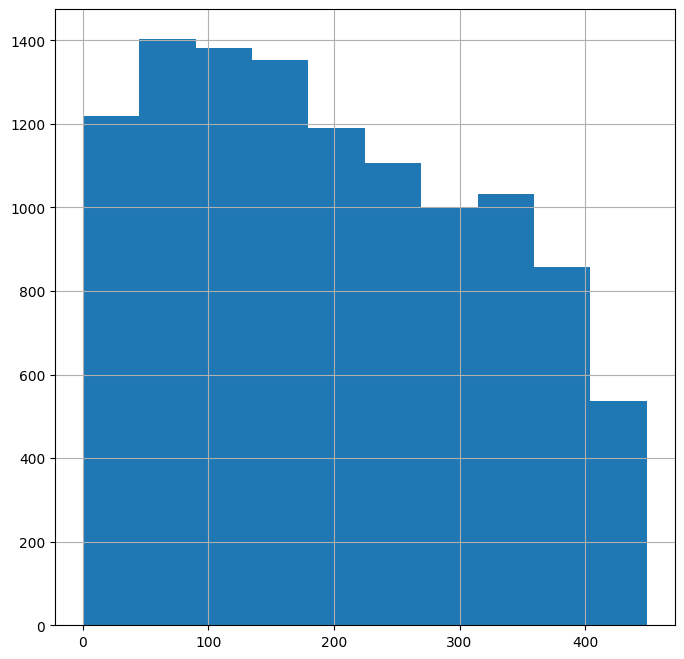

In [11]:
import matplotlib.pyplot as plt
import numpy as np

df.DEPTH_WMSF.hist(figsize=(8, 8));

In [12]:
df.munsel_color.value_counts().shape

(40,)

Then we are going to split the train: test = 0.7 : 0.3 by `DEPTH_WMSF`.

In [13]:
train_frac = int(df.shape[0]*.7)+1
train_frac

7756

In [14]:
sorted_df = df.sort_values(by=['DEPTH_WMSF'], ascending=True)
sorted_df

,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU,munsel_color,lithology,y
0,0.0724,5.8481,0.0959,1.3131,-0.1712,1950.0000,1765.0116,0.0915,5R 4 10,Sandy Mud,4
1,0.0736,0.5881,0.0116,0.1206,0.0077,46.6488,124.4472,1.5966,10PB 0.2 18,Sandy Mud,4
2,0.0880,1.9945,0.0354,0.4317,0.0501,1950.0000,1950.0000,0.1589,2.5YR 8 10,Interbedded sand and mud,1
3,0.0920,22.4306,0.6522,3.3707,0.0916,1950.0000,1950.0000,9700.0000,10PB 0.2 18,Sandy Mud,4
4,0.2248,7.6691,0.1369,1.6566,-0.2301,1950.0000,1765.0116,0.0915,10PB 0.2 18,Sandy Mud,4
...,...,...,...,...,...,...,...,...,...,...,...
11626,448.7536,47.1289,1.3832,7.0139,2.0609,1.1912,1.0928,0.6569,5P 3 6,Marl,2
11627,448.8916,24.7224,0.5522,4.6946,1.2829,0.9957,1.0211,0.8279,5P 3 6,Marl,2
11628,448.9060,47.6344,1.3817,7.1851,1.9657,1.1873,1.0805,0.5863,10PB 1 42,Mud,3
11629,449.0440,25.9426,0.5665,5.0022,1.1771,0.9915,1.0273,0.8255,5P 3 6,Marl,2


In [15]:
train_set = sorted_df.iloc[:train_frac]
test_set = sorted_df.iloc[train_frac:]

In [16]:
train_set.shape[0]/(test_set.shape[0]+train_set.shape[0])

0.7

We successfully split them!

### Important: visual check of train/test split

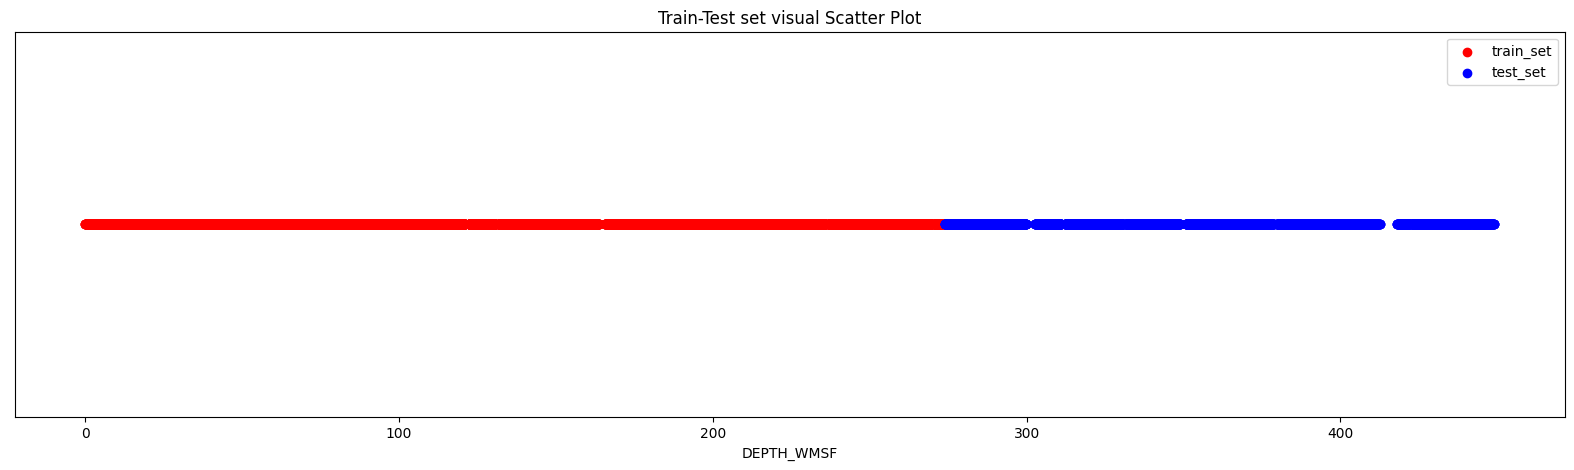

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

ax.scatter(train_set['DEPTH_WMSF'], [1] * len(train_set), c='r', label='train_set')
ax.scatter(test_set['DEPTH_WMSF'], [1] * len(test_set), c='b', label='test_set')

ax.set_xlabel('DEPTH_WMSF')
ax.set_ylim(0, 2)
ax.set_yticks([])
ax.legend()
plt.title('Train-Test set visual Scatter Plot')
plt.show()

After split the train set and test set, we are going to split them to X and y.

In [18]:
X_train = train_set.drop(["lithology"], axis=1).copy()
y_train = train_set.y
X_test = test_set.drop(["lithology"], axis=1).copy()
y_test = test_set.y

In [19]:
X_train_color = X_train.copy()
X_test_color = X_test.copy()

In [20]:
X_train_color

,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU,munsel_color,y
0,0.0724,5.8481,0.0959,1.3131,-0.1712,1950.0000,1765.0116,0.0915,5R 4 10,4
1,0.0736,0.5881,0.0116,0.1206,0.0077,46.6488,124.4472,1.5966,10PB 0.2 18,4
2,0.0880,1.9945,0.0354,0.4317,0.0501,1950.0000,1950.0000,0.1589,2.5YR 8 10,1
3,0.0920,22.4306,0.6522,3.3707,0.0916,1950.0000,1950.0000,9700.0000,10PB 0.2 18,4
4,0.2248,7.6691,0.1369,1.6566,-0.2301,1950.0000,1765.0116,0.0915,10PB 0.2 18,4
...,...,...,...,...,...,...,...,...,...,...
8136,273.7828,22.3937,0.4726,4.4135,1.1880,1.0736,1.1140,0.6077,5P 3 6,2
8137,273.7840,56.5277,1.4407,9.6910,2.1578,1.2697,1.2614,1.1236,10B 8 12,3
8138,273.7984,59.1977,1.5576,9.8627,2.7544,1.5905,1.3903,0.6885,2.5R 8 6,3
8139,273.9120,53.0798,1.5359,8.0245,2.2557,1.2995,1.0868,0.6589,5P 3 6,2


## Step 3: Transform `munsel_color` into values.

We noticed that column `munsel_color` is all string values. It describes sediment colors, aiding in identifying mineral content and environmental conditions, and thus lithology. Munsell color charts are used by sedimentologists and many other scientists. Converting the color to other system is not trivial: most of the time the color name itself is used, though conversion tables do exist. Then we import the conversion `table` and use this to redefine our column `munsel_color` as `munsel_color1`, `munsel_color2`, and `munsel_color3`.

In [21]:
from table import table
X_train_color['munsel_color1'] = X_train_color['munsel_color'].apply(lambda x: table[x][0])
X_train_color['munsel_color2'] = X_train_color['munsel_color'].apply(lambda x: table[x][1])
X_train_color['munsel_color3'] = X_train_color['munsel_color'].apply(lambda x: table[x][2])

In [22]:
X_train_color.head(5)

,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU,munsel_color,y,munsel_color1,munsel_color2,munsel_color3
0,0.0724,5.8481,0.0959,1.3131,-0.1712,1950.0000,1765.0116,0.0915,5R 4 10,4,0.5043,0.3176,12.000
1,0.0736,0.5881,0.0116,0.1206,0.0077,46.6488,124.4472,1.5966,10PB 0.2 18,4,0.1930,0.0120,0.237
2,0.0880,1.9945,0.0354,0.4317,0.0501,1950.0000,1950.0000,0.1589,2.5YR 8 10,1,0.4552,0.3761,59.100
3,0.0920,22.4306,0.6522,3.3707,0.0916,1950.0000,1950.0000,9700.0000,10PB 0.2 18,4,0.1930,0.0120,0.237
4,0.2248,7.6691,0.1369,1.6566,-0.2301,1950.0000,1765.0116,0.0915,10PB 0.2 18,4,0.1930,0.0120,0.237


Now, we have encodered our target `munsel_color` as `y`, which is our new target!

In [23]:
X_train_color.shape


(7756, 13)

## Step3: Missing Values and columns to remove

We are going to check is there missing value and is there columns need to be removed

In [24]:
X_train.isnull().sum()

DEPTH_WMSF      0
HCGR            0
HFK             0
HTHO            0
HURA            0
IDPH            0
IMPH            0
SFLU            0
munsel_color    0
y               0
dtype: int64

In [25]:
all_cols = X_train.isnull().sum().index
all_cols

Index(['DEPTH_WMSF', 'HCGR', 'HFK', 'HTHO', 'HURA', 'IDPH', 'IMPH', 'SFLU',
       'munsel_color', 'y'],
      dtype='object')

***Observation***: There is no missing value in the train set. We are not going to remove any column of this data.

### Range of values

Let's see what the range of our values are:

In [26]:
X_train[all_cols].describe()

,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU,y
count,7756.000000,7756.000000,7756.000000,7756.000000,7756.000000,7756.000000,7756.000000,7756.000000,7756.000000
mean,132.922561,36.424618,1.009740,5.765415,1.220650,476.044911,537.620354,796.146313,2.001805
std,76.562413,23.099325,0.688807,3.468377,0.721200,831.826138,841.441096,2661.304577,1.353076
min,0.072400,0.029500,-0.070000,-0.136600,-0.510500,0.339900,0.412000,0.091500,0.000000
25%,68.054800,11.663875,0.281750,2.169675,0.597575,1.235275,1.125175,0.608650,1.000000
50%,130.070200,38.063550,1.012000,6.094500,1.203350,1.496300,1.393250,0.748700,3.000000
75%,196.516300,55.705175,1.587700,8.563700,1.758050,46.648800,1765.011600,1.165400,3.000000
max,273.935200,93.633400,2.793700,16.031500,5.218600,1950.000000,1950.000000,9700.000000,4.000000


**Conclusions**: We see that we have negative values for different contribution. This is not physically possible, so we will replace those. We could replace them by `nan` values, or by `zero`. We will do the latter here, assuming that if values are negative they are below detection (and thus `=0`).

## Step4: Outlier & Scaler

In [27]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

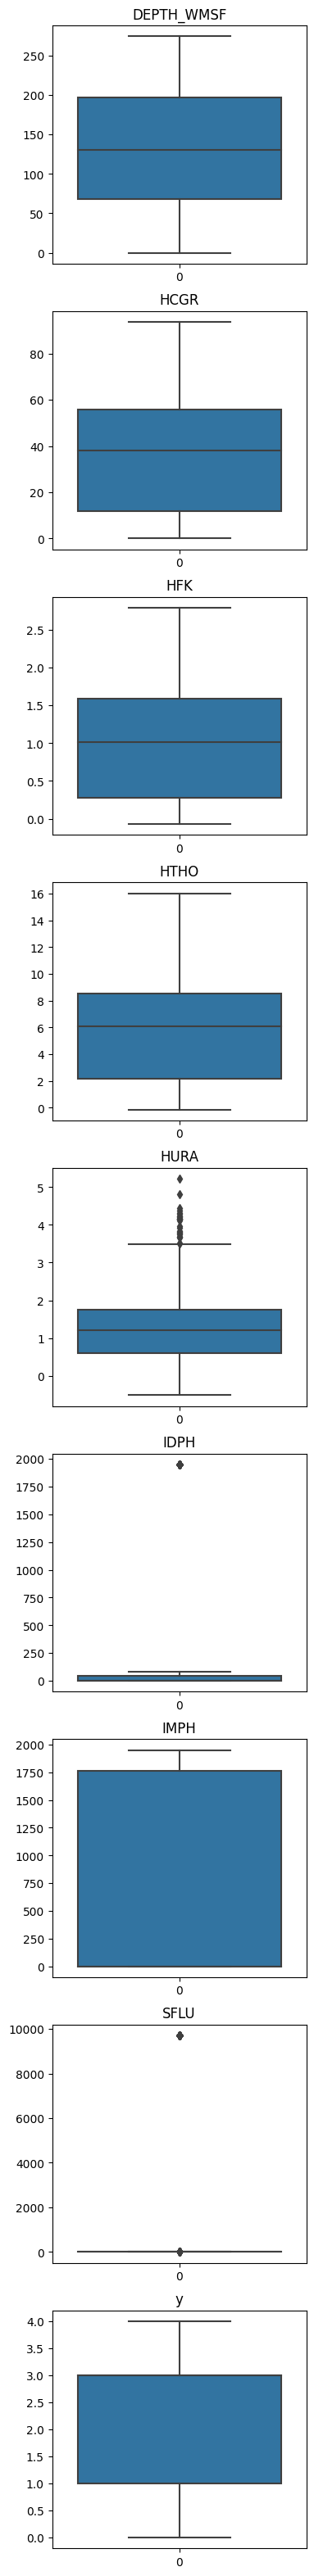

In [28]:
import seaborn as sns

fig, axes = plt.subplots(len(num_cols),1, figsize=(4,40))

for feature, ax in zip(X_train[num_cols], axes):
    sns.boxplot(data = X_train[feature], ax=ax);
    ax.set_title(feature)

**Conclusion:** The data does not have obvious outliers. And we are going to check the co-linearity and find whether we need take the log of other operations of any columns.

## Step5: Checking for strong co-linearity

we do not need the column `y` as a target and `munsel_color` has been transformed to three other columns.

In [29]:
num_cols = X_train_color.columns.tolist()
num_cols.remove('y')
num_cols.remove('munsel_color')
num_cols

['DEPTH_WMSF',
 'HCGR',
 'HFK',
 'HTHO',
 'HURA',
 'IDPH',
 'IMPH',
 'SFLU',
 'munsel_color1',
 'munsel_color2',
 'munsel_color3']

we are going to use the scatter matrix to find the co-linearity between columns

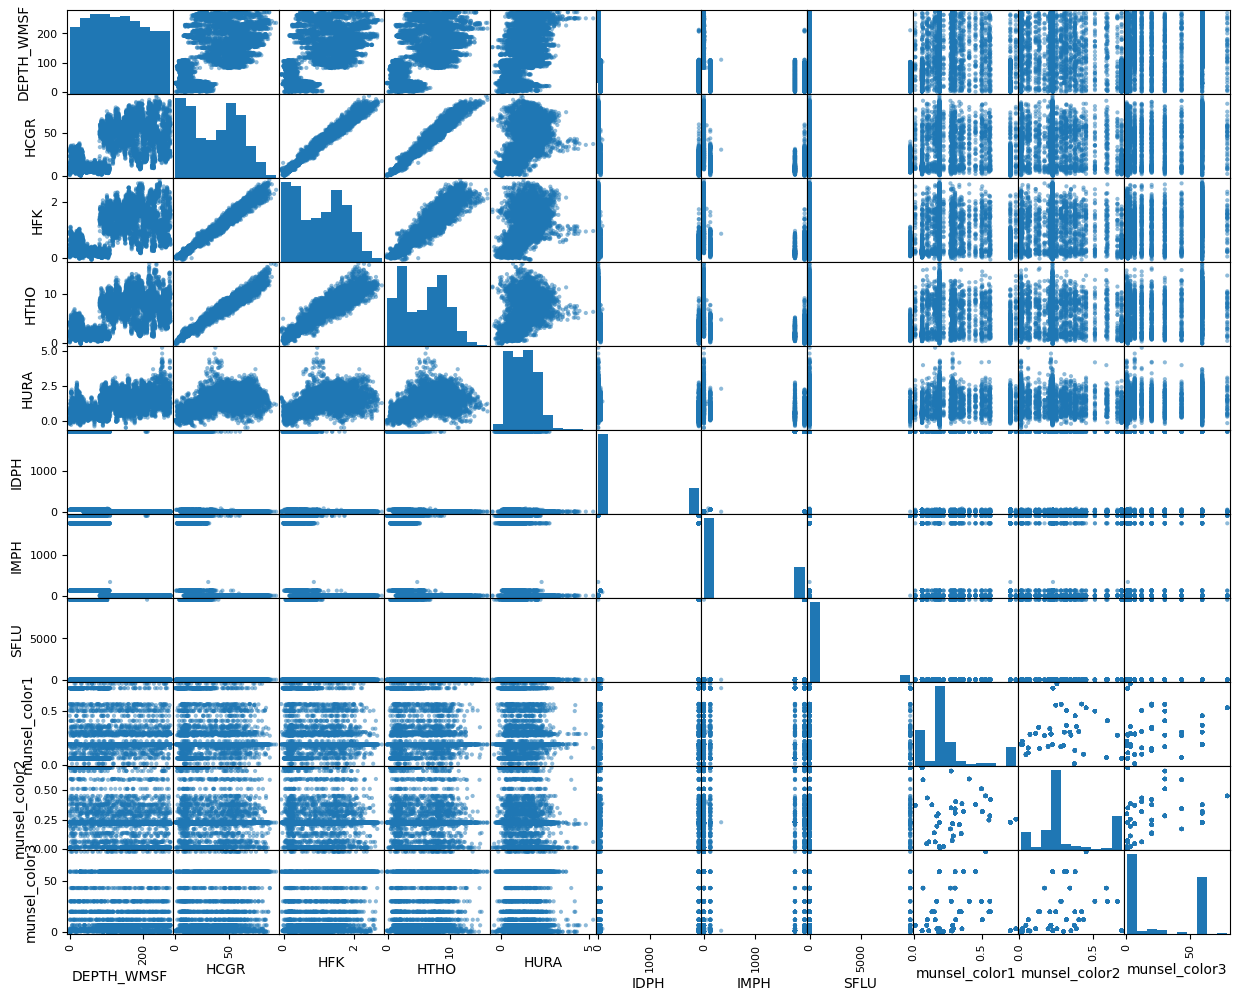

In [30]:
pd.plotting.scatter_matrix(X_train_color[num_cols], figsize=(15,12));

***Conclusion***: We see here `HCGR`~`HFK`, `HCGR`~`HTHO`, `HFK`~`HTHO` are firely strongly correlated, which means they may all correlated and we will check this later. It also appears that many of the feature distributions are non-gaussian. We will take the log of the features.

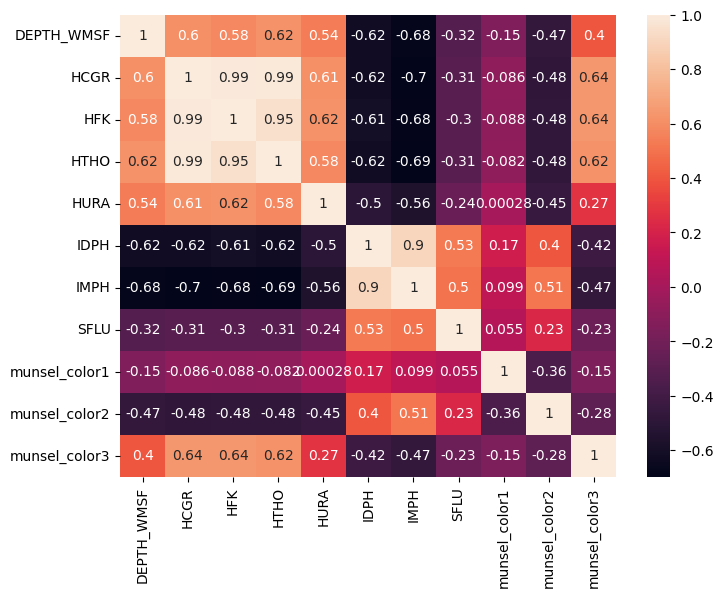

In [31]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(8,6))
corr = X_train_color[num_cols].corr()
sns.heatmap(data=corr, annot=corr, ax=ax);

This confirms that `HCGR`~`HFK`, `HCGR`~`HTHO`, `HFK`~`HTHO` are strongly correlated. We are going to drop `HFK` and `HTHO`, only keep the `HCGR`. And we also found that `IDPH` and `IMPH` are strongly correlated which is 0.91. We are going to drop `IMPH` and keep `IDPH`.

In [32]:
num_cols.remove('HFK')
num_cols.remove('HTHO')
num_cols.remove('IMPH')
num_cols

['DEPTH_WMSF',
 'HCGR',
 'HURA',
 'IDPH',
 'SFLU',
 'munsel_color1',
 'munsel_color2',
 'munsel_color3']

## Step6: Inspecting Numerical Features
We are going to explore the Numerical columns, and check how we are going to encode them.

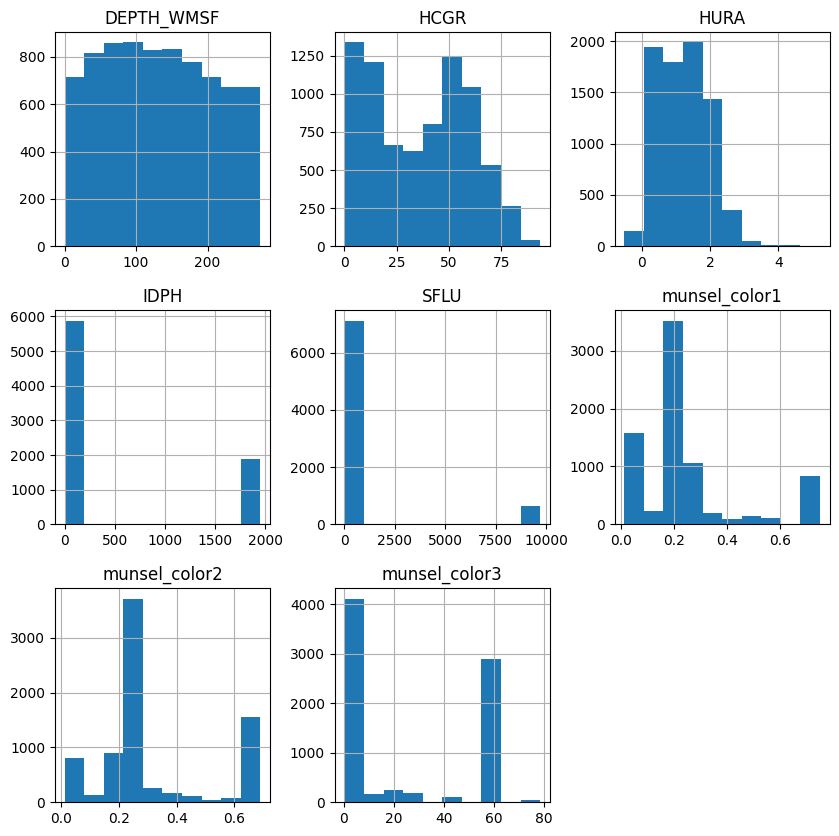

In [33]:
num_data = X_train_color[num_cols].select_dtypes(include = np.number)
num_data.hist(figsize=(10,10));

***Observation***: As we mentioned above, of the feature distributions `IDPH` and `SFLU` are non-gaussian. We are going to take the log of these two columns.

/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


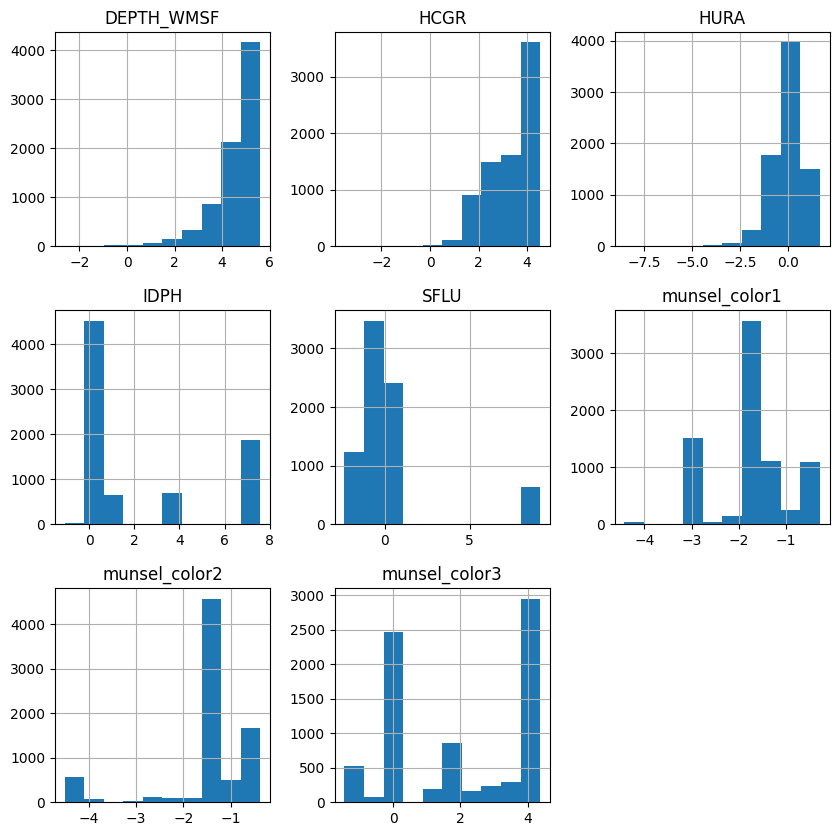

In [34]:
np.log(X_train_color[num_cols]+1e-10).hist(figsize=(10,10));

***Observation***: After taking the log, the feature distributions of `IDPH` and `SFLU` are better. We will do this in the later pipeline for these two columns.

In [35]:
to_log = ['IDPH', 'SFLU']
not_to_log = ['HCGR', 'HURA', 'munsel_color1', 'munsel_color2', 'munsel_color3']

## Step7: Building initial pipelines

Here, we are going to build the pipeline for the whole preprocessing process.
First, we need to write the LogTransformer Class to take the log of columns in `to_log`. And ZeroTransform Class to deal with the negative values.

In [36]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer

class LogTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, seed = 1e-5):
        self.seed=seed
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.log(X+self.seed)


class ZeroTransform(TransformerMixin, BaseEstimator):
    """This transformer replaces negative values by zeros: elemental concentrations cannot be < zero."""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X = np.where(X < 0, 0, X)
        return X

Then we write a ColorTransform Class to transform `munsel_color` column to three other columns.

In [37]:
class ColorTransform(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['munsel_color1'] = X['munsel_color'].apply(lambda x: table[x][0])
        X['munsel_color2'] = X['munsel_color'].apply(lambda x: table[x][1])
        X['munsel_color3'] = X['munsel_color'].apply(lambda x: table[x][2])
        X = X.drop("munsel_color", axis=1)
        return X
        

In [38]:
to_log_pipe = make_pipeline(SimpleImputer(), ZeroTransform(), LogTransformer(seed=6e-3), RobustScaler())
not_to_log_pipe = make_pipeline(SimpleImputer(), ZeroTransform(), RobustScaler())

We build the pipeline to deal with to_log columns and not_to_log columns, seperately.

In [39]:
proc_pipe = ColumnTransformer([
    ('to_log_transformer', to_log_pipe, X_train_color[to_log].columns),
    ('not_to_log_transformer', not_to_log_pipe, X_train_color[not_to_log].columns)
])

In [40]:
procession = make_pipeline(ColorTransform(), proc_pipe)
procession

Pipeline(steps=[('colortransform', ColorTransform()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('to_log_transformer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('zerotransform',
                                                                   ZeroTransform()),
                                                                  ('logtransformer',
                                                                   LogTransformer(seed=0.006)),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  Index(['IDPH', 'SFLU'], dtype='object')),
                                                 ('not_to_log_transformer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('zerotransform',
                                                                   ZeroTransform()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  Index(['HCGR', 'HURA', 'munsel_color1', 'munsel_color2', 'munsel_color3'], dtype='object'))]))])

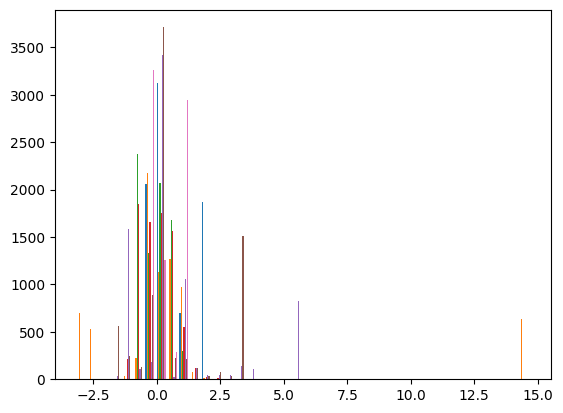

In [41]:
plt.hist(procession.fit_transform(X_train),bins=40);

***Observations***: We create the preprocess pipeline, and here is the distribution of the X_train data after fit_transformed by the pipeline!

# 🐠 PART B: Finding the best model

Once you understand your data, you can start to find the best model. Remember that IODP has a few criteria for you:
1. You must at least use the `munsell_color` feature in your model
2. You must write the entire model as a `pipeline` that can process raw data and return a prediction. Your estimator must be a `parametric model`, i.e. `model.coef_` must return the coefficients of the model.
3. Your model will be evaluated against performance on the unseen data. This will include checking how close your predicted `F1 macro` of your test set is to the `F1 macro` calculated by your model on the unseen data (IODP has secret labels for that).
4. Your model will also be evaluated for simplicity versus performance, i.e. the ratio of `F1 macro` on the unseen data against the `number of coefficients` (not their values) of your model.

Once you have defined and trained your best model, please run the cell below the next empty cell. This cell assumes that 1. your trained best model is called `best_model`, your `X_test` and your `y_test_cat` are named exactly like this (and `y_train_cat` represents the `y_test` transformed into categorical value. Running this cell will save values that will be used for automatic testing of your results, so this is important. If your variables have different names, you can change this code.

## Baseline model and score
First, we create a DummyClassifier as the model to predict as the baseline model and baseline score.

In [42]:
from sklearn.dummy import DummyClassifier

baseline_pipe = make_pipeline(procession, DummyClassifier(strategy='stratified', random_state=42))

baseline_pipe.fit(X_train, y_train)
baseline = baseline_pipe.predict(X_test)

In [43]:
f1_score(y_test, baseline, average='macro')

0.15170972792625087

The baseline score is 0.1517!

## First model: LogisticRegression
We are going to use the logistic regression model to deal with it.

In [44]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1500, random_state=42)

lr_pipe = make_pipeline(procession, lr_model)

lr_pipe.fit(X_train, y_train)
lr_result = lr_pipe.predict(X_test)
f1_score(y_test, lr_result, average='macro')

0.8841786586815829

And we do RandomizedSearchCV to find whether there are better parameters.

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

grid = {
    'logisticregression__C':stats.uniform(0.00001, 10),
    'logisticregression__class_weight':[None,'balanced'],
    'logisticregression__multi_class':['multinomial','ovr']
}

search = RandomizedSearchCV(lr_pipe, param_distributions=grid, scoring='f1_macro', cv=5, n_jobs=-1)

In [46]:
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('colortransform',
                                                               ColorTransform()),
                                                              ('columntransformer',
                                                               ColumnTransformer(transformers=[('to_log_transformer',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer()),
                                                                                                                ('zerotransform',
                                                                                                                 ZeroTransform()),
                                                                                                                ('logtransformer',
                                                                                                                 LogTransformer(seed=0.006)),
                                                                                                                ('robustscaler',
                                                                                                                 RobustScaler())...
                                                                                                Index(['HCGR', 'HURA', 'munsel_color1', 'munsel_color2', 'munsel_color3'], dtype='object'))]))])),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=1500,
                                                                 random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x150dd6710>,
                                        'logisticregression__class_weight': [None,
                                                                             'balanced'],
                                        'logisticregression__multi_class': ['multinomial',
                                                                            'ovr']},
                   scoring='f1_macro')

In [47]:
best_estimator = search.best_estimator_
best_estimator

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('colortransform', ColorTransform()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('to_log_transformer',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('zerotransform',
                                                                                    ZeroTransform()),
                                                                                   ('logtransformer',
                                                                                    LogTransformer(seed=0.006)),
                                                                                   ('robustscaler',
                                                                                    RobustScaler())]),
                                                                   Index(['IDPH', 'SFLU'], dtype='ob...
                                                                  ('not_to_log_transformer',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('zerotransform',
                                                                                    ZeroTransform()),
                                                                                   ('robustscaler',
                                                                                    RobustScaler())]),
                                                                   Index(['HCGR', 'HURA', 'munsel_color1', 'munsel_color2', 'munsel_color3'], dtype='object'))]))])),
                ('logisticregression',
                 LogisticRegression(C=0.07554084951628874, max_iter=1500,
                                    multi_class='multinomial',
                                    random_state=42))])

In [48]:
best_score = search.best_score_
best_score

0.8571750296918896

In [49]:
best_estimator.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('colortransform', ColorTransform()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('to_log_transformer',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('zerotransform',
                                                                                    ZeroTransform()),
                                                                                   ('logtransformer',
                                                                                    LogTransformer(seed=0.006)),
                                                                                   ('robustscaler',
                                                                                    RobustScaler())]),
                                                                   Index(['IDPH', 'SFLU'], dtype='ob...
                                                                  ('not_to_log_transformer',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('zerotransform',
                                                                                    ZeroTransform()),
                                                                                   ('robustscaler',
                                                                                    RobustScaler())]),
                                                                   Index(['HCGR', 'HURA', 'munsel_color1', 'munsel_color2', 'munsel_color3'], dtype='object'))]))])),
                ('logisticregression',
                 LogisticRegression(C=0.07554084951628874, max_iter=1500,
                                    multi_class='multinomial',
                                    random_state=42))])

In [50]:
pred = best_estimator.predict(X_test)
f1_score(pred, y_test, average='macro')

0.8808059785794805

In [51]:
best_params = search.best_params_
best_params

{'logisticregression__C': 0.07554084951628874,
 'logisticregression__class_weight': None,
 'logisticregression__multi_class': 'multinomial'}

## The Second Model SVC(kernel='linear')

We are going to use svc(kernel='linear') to do this.

In [52]:
from sklearn.svm import SVC

svc = SVC(kernel='linear', random_state=42)

svc_pipe = make_pipeline(procession, svc)

svc_pipe.fit(X_train, y_train)
svc_result = svc_pipe.predict(X_test)
f1_score(y_test, svc_result, average='macro')

0.8866387815450207

Then, we are going to do grid research for the second SVC(lernel='linear') model

In [53]:
svc = SVC(kernel='linear')

svc_pipe = make_pipeline(procession, svc)

grid = {
    'svc__C':[0.001, 0.01, 0.1, 1, 10],
    'svc__gamma':['scale', 'auto', 0.1, 1, 10]
}

search = GridSearchCV(svc_pipe, grid, 
                           scoring = 'f1_macro',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          ) 


In [54]:
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('colortransform',
                                                         ColorTransform()),
                                                        ('columntransformer',
                                                         ColumnTransformer(transformers=[('to_log_transformer',
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('zerotransform',
                                                                                                           ZeroTransform()),
                                                                                                          ('logtransformer',
                                                                                                           LogTransformer(seed=0.006)),
                                                                                                          ('robustscaler',
                                                                                                           RobustScaler())]),
                                                                                          Ind...
                                                                                          Pipeline(steps=[('simpleimputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('zerotransform',
                                                                                                           ZeroTransform()),
                                                                                                          ('robustscaler',
                                                                                                           RobustScaler())]),
                                                                                          Index(['HCGR', 'HURA', 'munsel_color1', 'munsel_color2', 'munsel_color3'], dtype='object'))]))])),
                                       ('svc', SVC(kernel='linear'))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 10],
                         'svc__gamma': ['scale', 'auto', 0.1, 1, 10]},
             scoring='f1_macro')

In [55]:
search.best_score_

0.8685820179200674

In [56]:
svc_search = search.best_estimator_
svc_search.fit(X_train, y_train)
f1_score(y_test, svc_search.predict(X_test), average='macro')

0.8866047280744952

In [57]:
from sklearn.inspection import permutation_importance
svc_pipe.fit(X_train, y_train)
permutation_score = permutation_importance(svc_pipe, X_train, y_train, n_repeats=10)

In [58]:
import numpy as np
importance_df = pd.DataFrame(np.vstack((X_train.columns,
                                        permutation_score.importances_mean)).T) # Unstack results
importance_df.columns=['feature','score decrease']

importance_df.sort_values(by="score decrease", ascending = False) # Order by importance

,feature,score decrease
8,munsel_color,0.346519
1,HCGR,0.253894
5,IDPH,0.132581
4,HURA,0.045887
7,SFLU,0.008381
0,DEPTH_WMSF,0.0
2,HFK,0.0
3,HTHO,0.0
6,IMPH,0.0
9,y,0.0


The `y` is our target, `HFK`, `HTHO`, `IMPH`, and `DEPTH_WMSF` are the columns that we have already dropped, which the model will not concerned. Then `SFLU` is less important than the other features. The original of our best is 0.8866, let's check if we remove this columns!

In [59]:
proc_pipe2 = ColumnTransformer([
    ('to_log_transformer', to_log_pipe, X_train_color[['IDPH']].columns),
    ('not_to_log_transformer', not_to_log_pipe, X_train_color[not_to_log].columns)
])

In [60]:
procession2 = make_pipeline(ColorTransform(), proc_pipe2)

In [61]:
from sklearn.svm import SVC

svc = SVC(kernel='linear', random_state=42)

svc_pipe = make_pipeline(procession2, svc)

svc_pipe.fit(X_train, y_train)
svc_result = svc_pipe.predict(X_test)
f1_score(y_test, svc_result, average='macro')

0.8867740660996138

It increase to 0.8867! So we need to drop this column and also in the folloing part3. Then we record our `best_model`! and the corresponding `y_test_cat`!

In [62]:
best_model = svc_pipe
y_test_cat = y_test

Finally, we are going to use this model to predict the new_data.csv!

In [63]:
new_samples_prediction = best_model.predict(new_samples)
new_samples_prediction

array([2, 3, 2, ..., 4, 2, 4])

There is no decoder here and the return value is number, the decoder is writen in the PART C CLass by function _predict()_!

In [64]:
# RUN THIS CELL TO SAVE YOUR SCORES TO DISC - ESSENTIAL FOR AUTOMATIC TESTING

from sklearn.metrics import f1_score

pd.Series(f1_score(y_test_cat, best_model.predict(X_test), average='macro'), name='f1_test').to_csv('f1_test.csv', index=False)
pd.Series(best_model.predict(X_test), name='y_pred').to_csv('y_pred_notebook.csv', index=False)

# 🦈 PART C: Write the `LithoEstimator` Class

This is the final piece of the assignment. If you open the `litho_estimator.py` file you will see that the skeleton of a class called `LithoEstimator` has been created for you. Your job is to finish the class in the file, based on what you found out in **parts A and B**. I expect this class to have the following behaviour:

1. When a new instance of the class is created, it will automatically create a machine learning model (a pipeline with an estimator) that is defined in the same way as your most performant algorithm. That is to say, use the same parameters (and hyperparameters) than you best estimator, but do not do any EDA or hyperparameter tuning (this would be done in **parts A and B** in this notebook).
2. At initialisation time, you need to create the variables `self.X_train`, `self.X_test`, `self.y_train` and `self.y_test`.
3. The class will automatically train your algorithm on the `X_train` and `y_train`
4. The `x_test_score(self)` method should return the `f1_score` with `average=macro` of your predicted `X_test`.
5. The `get_Xs(self)` method should return `X_train` and `X_test`
6. The `get_ys(self)` method should return `y_train` and `y_test`
7. The `predict(self, path_to_new_file)` method should return the `y_pred` (predictions) for any file path we give to the method. The default value for `path_to_new_file` is already set for you as the `new_data.csv` file.
8. The `get_model(self)` method should return the entire **trained model** (pipeline) that includes the final predictor. I recommend you save your model as an instance variable (`self.model`).
9. You can add as many other methods as needed, or write additional classes such as custom transformers or others in the same python file.

If you want a rough test of your code, you can try to run the cells below:

In [65]:
from litho_estimator import LithoEstimator

model = LithoEstimator()

model.get_Xs() # Should return your untransformed X_train and X_test

/opt/homebrew/Caskroom/miniconda/base/envs/dsml4p/lib/python3.11/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(      DEPTH_WMSF     HCGR     HFK    HTHO    HURA       IDPH       IMPH  \
 0         0.0724   5.8481  0.0959  1.3131 -0.1712  1950.0000  1765.0116   
 1         0.0736   0.5881  0.0116  0.1206  0.0077    46.6488   124.4472   
 2         0.0880   1.9945  0.0354  0.4317  0.0501  1950.0000  1950.0000   
 3         0.0920  22.4306  0.6522  3.3707  0.0916  1950.0000  1950.0000   
 4         0.2248   7.6691  0.1369  1.6566 -0.2301  1950.0000  1765.0116   
 ...          ...      ...     ...     ...     ...        ...        ...   
 8137    273.7840  56.5277  1.4407  9.6910  2.1578     1.2697     1.2614   
 8138    273.7984  59.1977  1.5576  9.8627  2.7544     1.5905     1.3903   
 8139    273.9120  53.0798  1.5359  8.0245  2.2557     1.2995     1.0868   
 8140    273.9352  22.2440  0.4673  4.3964  1.2078     1.0600     1.1055   
 8141    273.9364  53.0431  1.3778  8.9417  2.2143     1.2813     1.2843   
 
            SFLU munsel_color  
 0        0.0915      5R 4 10  
 1        1.5966  10PB

In [66]:
model.get_ys() # Should return your  y_train and y_test

(                      lithology
 0                     Sandy Mud
 1                     Sandy Mud
 2     Interbedded sand and mud 
 3                     Sandy Mud
 4                     Sandy Mud
 ...                         ...
 8137                        Mud
 8138                        Mud
 8139                       Marl
 8140                       Marl
 8141                       Marl
 
 [8142 rows x 1 columns],
       lithology
 8142        Mud
 8143        Mud
 8144       Marl
 8145       Marl
 8146        Mud
 ...         ...
 11626      Marl
 11627      Marl
 11628       Mud
 11629      Marl
 11630       Mud
 
 [3489 rows x 1 columns])

In [67]:
model.x_test_score() # Should return your test F1 score macro

0.8837653851645976

In [68]:
model.predict() # Should return an array or a Series of your predictions for the new samples

array(['Marl', 'Mud', 'Marl', ..., 'Sandy Mud', 'Marl', 'Sandy Mud'],
      dtype=object)

In [69]:
model.get_model() # Should return your trained pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('colortransform', ColorTransform()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('to_log_transformer',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('zerotransform',
                                                                                    ZeroTransform()),
                                                                                   ('logtransformer',
                                                                                    LogTransformer(seed=0.006)),
                                                                                   ('robustscaler',
                                                                                    RobustScaler())]),
                                                                   Index(['IDPH'], dtype='object')),
                                                                  ('not_to_log_transformer',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('zerotransform',
                                                                                    ZeroTransform()),
                                                                                   ('robustscaler',
                                                                                    RobustScaler())]),
                                                                   Index(['HCGR', 'HURA', 'munsel_color1', 'munsel_color2', 'munsel_color3'], dtype='object'))]))])),
                ('svc', SVC(kernel='linear'))])